## 3. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

`LinearRegression` 클래스는 예측값과 실제값의 `RSS(Residaul Sum of Squares)`를 최소화해 `OLS(Oridinary Leasy Squares)` 추정 방식으로 구현한 클래스이다.  
  
OLS 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받는다. 피처간의 상관관계가 매우 높은 경우 분산이 커져서 오류에 매우 민감해진다. 이러한 현상을 __다중공산성(multi-collinearity)__ 이라 한다.  
  
일반적으로 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용한다. 또한 매우 많은 피처가 다중 공산성 문제를 가지고 있다면 `PCA`를 통해 차원 축소를 수행하는 것도 고려해 볼 수 있다.

### 회귀 평가 지표

회귀의 평가를 위한 지표는 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심이다.  
일반적으로 회귀의 성능을 평가하는 지표는 다음과 같다

* __MAE__ : Mean Absolute Error(MAE)이며 실제값과 예측값의 차이를 절댓값으로 변환한 평균  
$$MAE = \frac{1}{n} \sum_{i=1}^n \vert (Y_i - \hat Y_i) \vert $$  
* __MSE__ : Mean Squared Error(MSE)이며 실제 값과 예측값 사이를 제곱해 평균한 것  
$$MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat Y_i)^2$$  
* __RMSE__ : MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있으므로 MSE에 루트를 씌운 것  
$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (Y_i - \hat Y_i)^2}$$  
* $R^2$ : 분산 기반으로 예측 성능을 평가. 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음  
$$ R^2 = \frac{\text{Forecast Variance}}{\text{Actual Variance}}$$

`cross_val_score`, `GridSearchCV`와 같은 Scoring 함수에 회귀 평가 지표를 적용할 때 한 가지 유의점이 있다.  
  
__MAE__ 의 파라미터 값을 살펴보면 `neg_mean_absolute_error`와 같이 '`neg_`라는 접두어가 붙어있다. 이는 __Negative__(음수)값을 가진다는 말인데, MAE는 절대값의 합이므로 음수값을 가질 수가 없다.  
Scoring 함수에 `neg_mean_absolute_error`을 적용하는 이유는 사이킷런의 Scoring 함수가 score값이 클수록 좋은 평가 결과로 자동 평가하기 때문이다  
  
그런데 실제 값과 예측값의 오류 차이를 기반으로 하는 회귀 평가 지표의 경우 값이 커지면 오히려 나쁜 모델이라는 의미이므로 이를 사이킷런의 Scoring 함수에 일반적으로 반영하려면 보정이 필요하다.  
  
따라서 -1을 원래 평가 지표 값에 곱해서 음수를 만들어 작은 오류값을 큰 값으로 인식하게 한다.

### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


* CRIM: 지역별 범죄 발생률  
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* NDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

* 각 컬럼별로 주택가격에 미치는 영향도를 조사

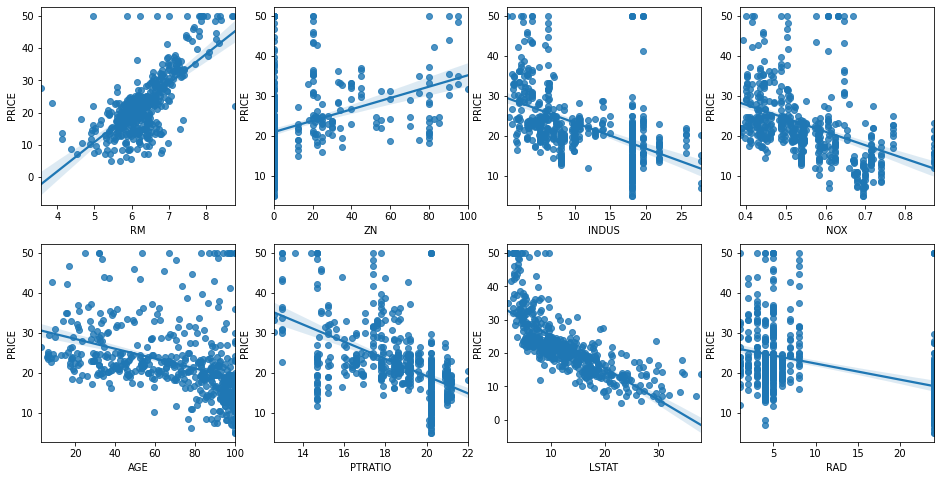

In [2]:
# 2개의 행과 4개의 열을 가진 subplots를 이용, axs는 4x2개의 ax를 가짐
fig, ax = plt.subplots(figsize = (16,8), ncols = 4, nrows = 2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']

for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # seaborn의 regplot를 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x = feature, y = 'PRICE', data = bostonDF, ax = ax[row][col])

`RM` 칼럼과 `LSTAT` 칼럼의 PRICE 영향도가 두드러지게 나타남  
__RM(방 개수)__ 가 많을수록 Price가 증가, __LSTAT(하위 계층 비율)__ 이 적을수록 Price 증가

**학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [5]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164336
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [8]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index = column명
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [11]:
# 5개의 폴드 세트에서 cross_val_score()를 이용해 교차 검증으로 MSE, RMSE 측정
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 
